Import the data and libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from pygam import LogisticGAM
import matplotlib.pyplot as plt

In [15]:
file_path = "energia.csv"
dataset = pd.read_csv(file_path, encoding='ISO-8859-1')
print(dataset.head())


   Unnamed: 0  Id_Cliente  Id_Sito Categoria_cliente  anno_nascita_cliente  \
0           1        2031     6730               AZN                   NaN   
1           2        5163     6209               AZN                   NaN   
2           3       10071    12219              PRIV                  35.0   
3           4       10664    12938               AZN                   NaN   
4           5       10904    13209              PRIV                  71.0   

   mese_nascita_cliente  giorno_nascita_cliente  sesso_cliente  Comune_sede  \
0                   NaN                     NaN            NaN       100005   
1                   NaN                     NaN            NaN        48017   
2                   3.0                     4.0            2.0       108030   
3                   NaN                     NaN            NaN        48043   
4                   8.0                    22.0            2.0        13043   

   Comune_sped  ...  altitudine  montano  superficie urb

In [3]:
dataset.shape
# we have 187172 rows and 29 colums

(187172, 29)

In [4]:
dataset.head()

,Unnamed: 0,Id_Cliente,Id_Sito,Categoria_cliente,anno_nascita_cliente,mese_nascita_cliente,giorno_nascita_cliente,sesso_cliente,Comune_sede,Comune_sped,...,altitudine,montano,superficie,urbanizzazione,long,lati,time,mese,kWh,kWh_giorn
0,1,2031,6730,AZN,NaN,NaN,NaN,NaN,100005,100005,...,230,1,182,1,9.189982,45.46420,1,10,2181,70.354839
1,2,5163,6209,AZN,NaN,NaN,NaN,NaN,48017,48017,...,230,1,182,1,9.189982,45.46420,1,10,618,19.935484
2,3,10071,12219,PRIV,35.0,3.0,4.0,2.0,108030,108030,...,341,1,8,2,9.152425,45.66112,1,10,579,18.677419
3,4,10664,12938,AZN,NaN,NaN,NaN,NaN,48043,48043,...,222,1,17,1,9.298131,45.49200,1,10,567,18.290323
4,5,10904,13209,PRIV,71.0,8.0,22.0,2.0,13043,13043,...,563,1,6,2,9.125326,45.77277,1,10,360,11.612903


# Temporal analysis

In [5]:
# create column for year
start_year = 2016
start_month = 10  

dataset['year'] = start_year + (dataset['time'] + (start_month - 1) - 1) // 12
dataset['month_num'] = ((dataset['time'] + (start_month - 1) - 1) % 12) + 1
dataset['month_year'] = dataset['month_num'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%b')) + ' ' + dataset['year'].astype(str)


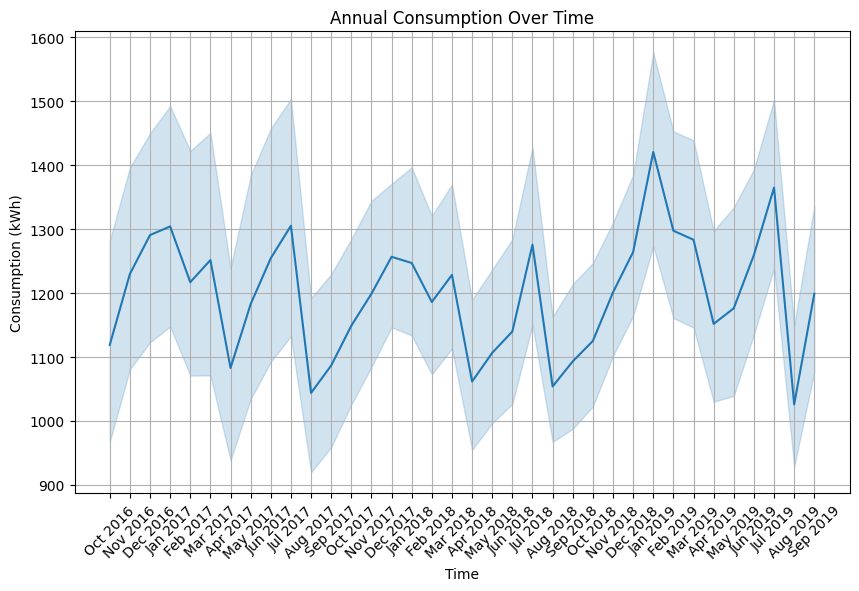

<Figure size 640x480 with 0 Axes>

In [8]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.lineplot(x='month_year', y='kWh', data=dataset)
plt.title('Annual Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Consumption (kWh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
plt.savefig("/plots/consumption_year.png")

There is a stagionality in the energy consumption. with peaks in December and July, probably due to the high consumptio of heating and AC. The consumption in 2019 is slightly higher compared to 2018 and 2017.

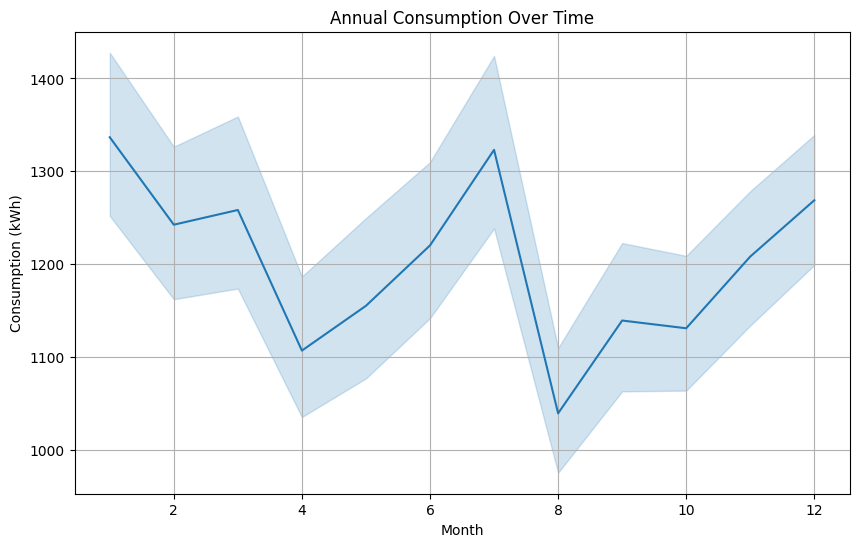

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='mese', y='kWh', data=dataset)
plt.title('Annual Consumption Over Time')
plt.xlabel('Month')
plt.ylabel('Consumption (kWh)')
plt.grid(True)
plt.show()


July is on average the month with the highest consumption, follwed by December and January, as previously highlighted.

# Client category analysis

In [9]:
# Count the number of observations for each category
category_counts = dataset['Categoria_cliente'].value_counts()

# Convert to a DataFrame for a cleaner table view
category_counts_df = category_counts.reset_index()
category_counts_df.columns = ['Categoria_cliente', 'Number of Observations']

# Display the table
print(category_counts_df)


  Categoria_cliente  Number of Observations
0              PRIV                   90875
1               AZN                   67462
2              PAMM                   20063
3              COND                    5553
4              NPRO                    3070
5              GENP                     149


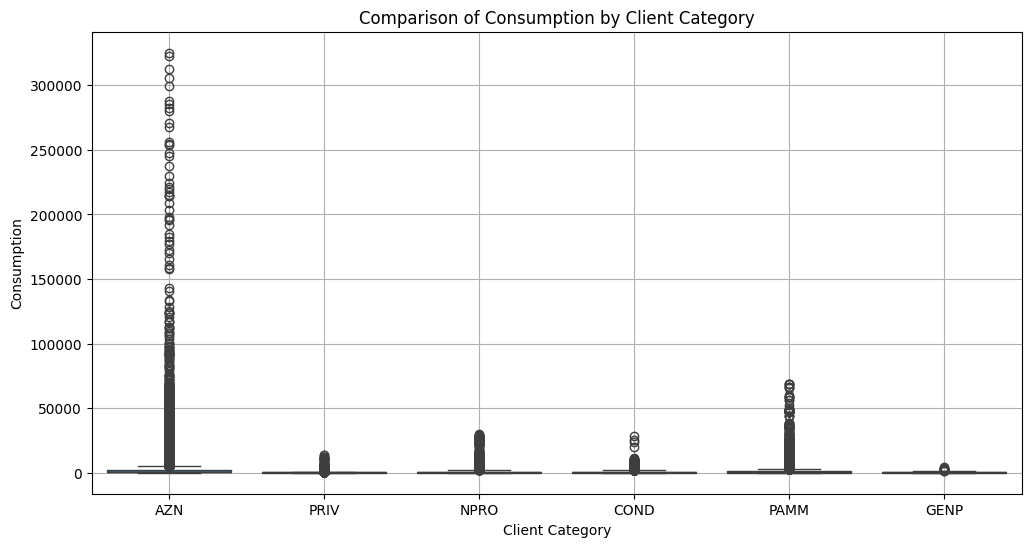

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Categoria_cliente', y='kWh', data=dataset, 
            order=dataset['Categoria_cliente'].unique())  # or specify a specific order if needed
plt.title('Comparison of Consumption by Client Category')
plt.xlabel('Client Category')
plt.ylabel('Consumption')
plt.grid(True)
plt.show()


Industries have far higher consumption levels compared to the other categories which is immaginable also due to the size of the building and activities. Also public administration and non profit organizations have high consumption levels.

In [12]:
# Filter the dataset for the categories of interest
filtered_data = dataset[dataset['Categoria_cliente'].isin(['PRIV', 'PAMM', 'AZN'])]
# Compute summary statistics
summary_stats = filtered_data.groupby('Categoria_cliente')['Consumo_Annuo'].describe()

# Display the summary statistics
print(summary_stats)

                     count          mean           std   min     25%     50%  \
Categoria_cliente                                                              
AZN                67462.0  26462.838057  86675.376604  23.0  3000.0  8066.0   
PAMM               20063.0  14882.458406  39423.446588   0.0  1077.0  3968.0   
PRIV               90875.0   2627.876941   2359.140235   1.0  1338.0  2148.0   

                       75%        max  
Categoria_cliente                      
AZN                23700.0  3500000.0  
PAMM               13992.0   700000.0  
PRIV                3210.0    66000.0  


# Analysis of private clients

In [13]:
# Filter the dataset for 'PRIV' category
priv_data = dataset[dataset['Categoria_cliente'] == 'PRIV']



In [14]:
# Descriptive statistics for numerical variables
numerical_vars = ['anno_nascita_cliente', 'altitudine', 'superficie']
desc_stats = priv_data[numerical_vars].describe()

print(desc_stats)


       anno_nascita_cliente    altitudine    superficie
count          90875.000000  90875.000000  90875.000000
mean              63.972138    392.402982     37.560066
std               15.544451    237.182208     53.920800
min                0.000000      3.000000      1.000000
25%               54.000000    250.000000      9.000000
50%               66.000000    301.000000     13.000000
75%               75.000000    401.000000     33.000000
max               99.000000   1152.000000    227.000000


In [15]:
# Frequency distribution for categorical variables
categorical_vars = ['sesso_cliente', 'zona_altimetrica', 'montano', 'urbanizzazione']
for var in categorical_vars:
    print(f"Frequency distribution for {var}:")
    print(priv_data[var].value_counts())
    print()


Frequency distribution for sesso_cliente:
sesso_cliente
2.0    53839
1.0    37036
Name: count, dtype: int64

Frequency distribution for zona_altimetrica:
zona_altimetrica
5    65588
3    17693
1     7594
Name: count, dtype: int64

Frequency distribution for montano:
montano
1    79890
3     8684
2     2301
Name: count, dtype: int64

Frequency distribution for urbanizzazione:
urbanizzazione
1    41925
2    40349
3     8601
Name: count, dtype: int64



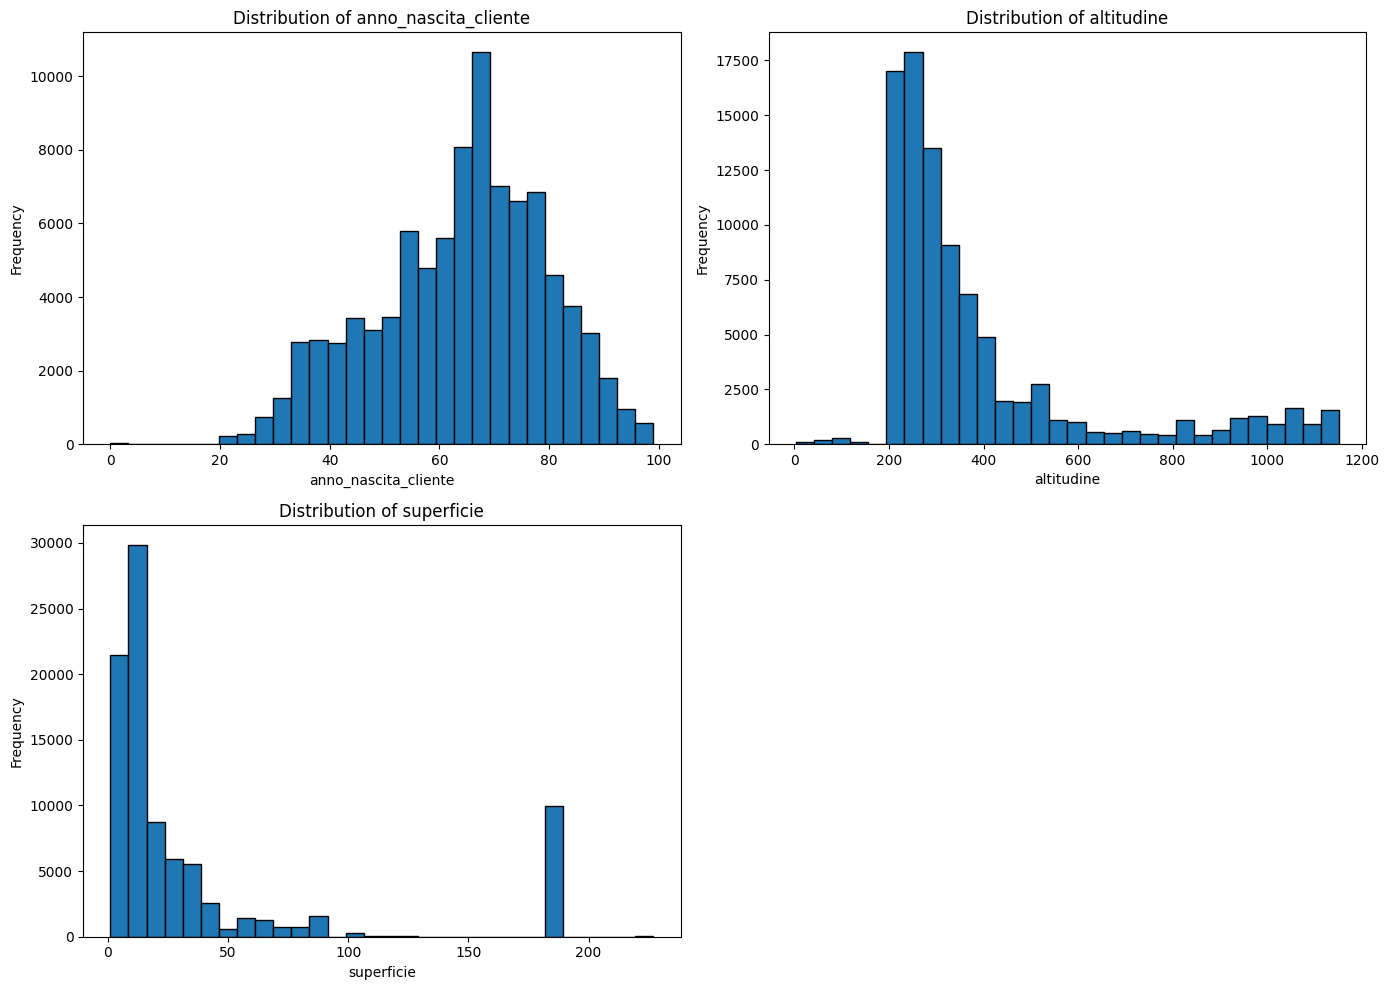

In [16]:
import matplotlib.pyplot as plt

# Plot histograms for numerical variables
plt.figure(figsize=(14, 10))
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 2, i)
    plt.hist(priv_data[var].dropna(), bins=30, edgecolor='k')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



The age distribution is very similar to the one of Italy with a high average age which in this case is even higher beacuse young people live with their parents. The amjority of people live at a low altitude but there are however people who live in the mountains. The majority of people live in small-medium sized towns but there are also big cities.

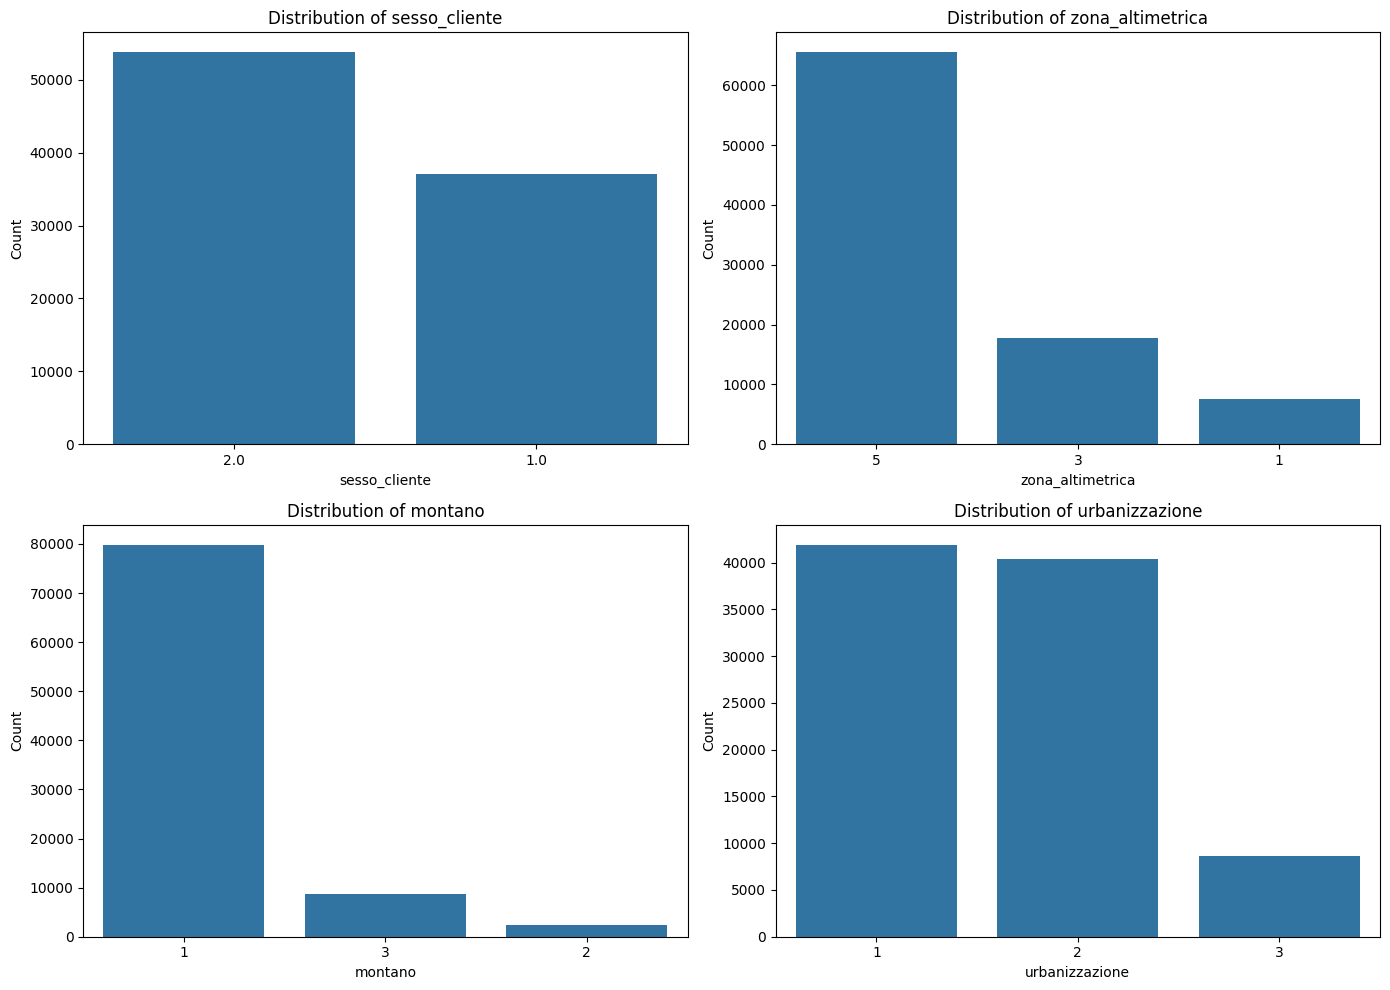

In [18]:
plt.figure(figsize=(14, 10))
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=var, data=priv_data, order=priv_data[var].value_counts().index)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


The number of males is similar to females; as seen from the altitued the majority of people live in plains; the majority of people also lives in urbanized areas. 

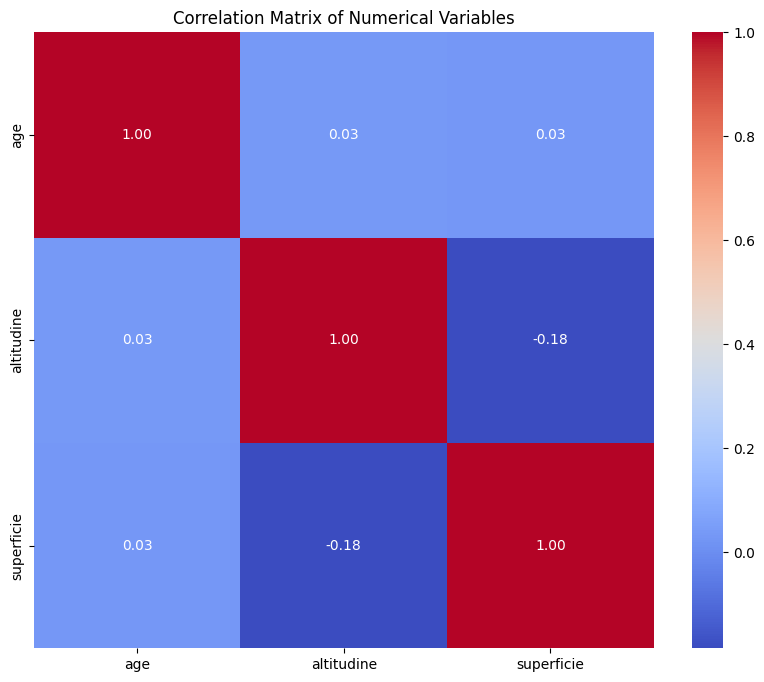

In [38]:
# Compute the correlation matrix
correlation_matrix = priv_data[numerical_vars].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()


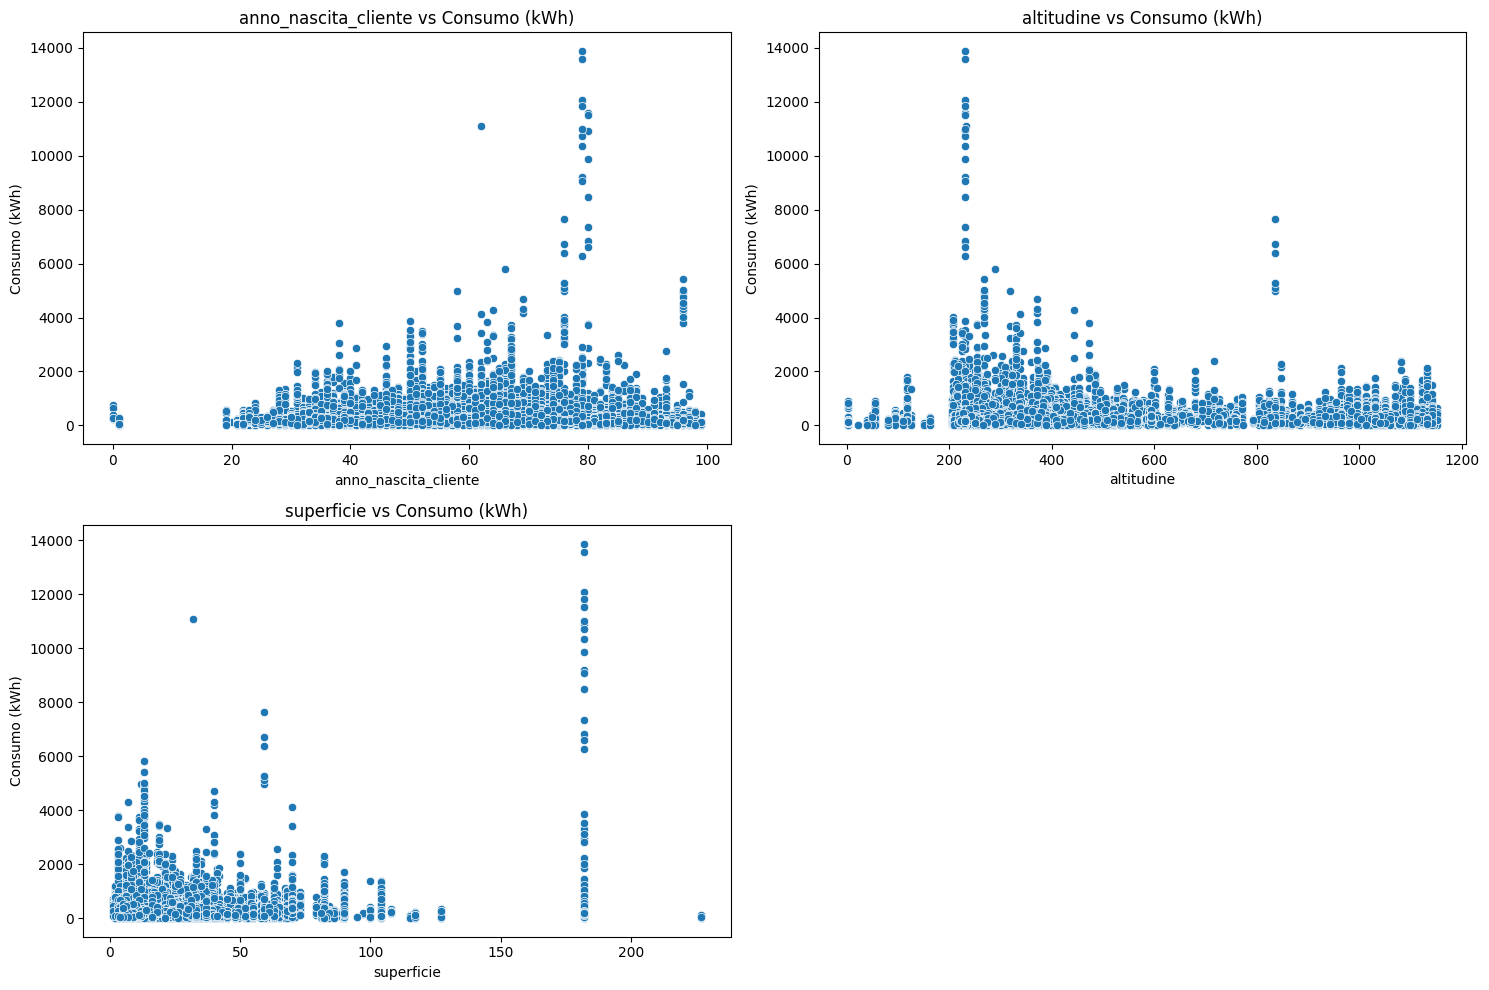

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plots to explore relationships with Consumo_Annuo
numerical_vars = ['anno_nascita_cliente', 'altitudine', 'superficie']

plt.figure(figsize=(15, 10))
for i, var in enumerate(numerical_vars, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=var, y='kWh', data=priv_data)
    plt.title(f'{var} vs Consumo (kWh)')
    plt.xlabel(var)
    plt.ylabel('Consumo (kWh)')

plt.tight_layout()
plt.show()


The Kwh is homogeneously distributed among age, altitude and surface. There are some peaks for very big cities and high altitudes.

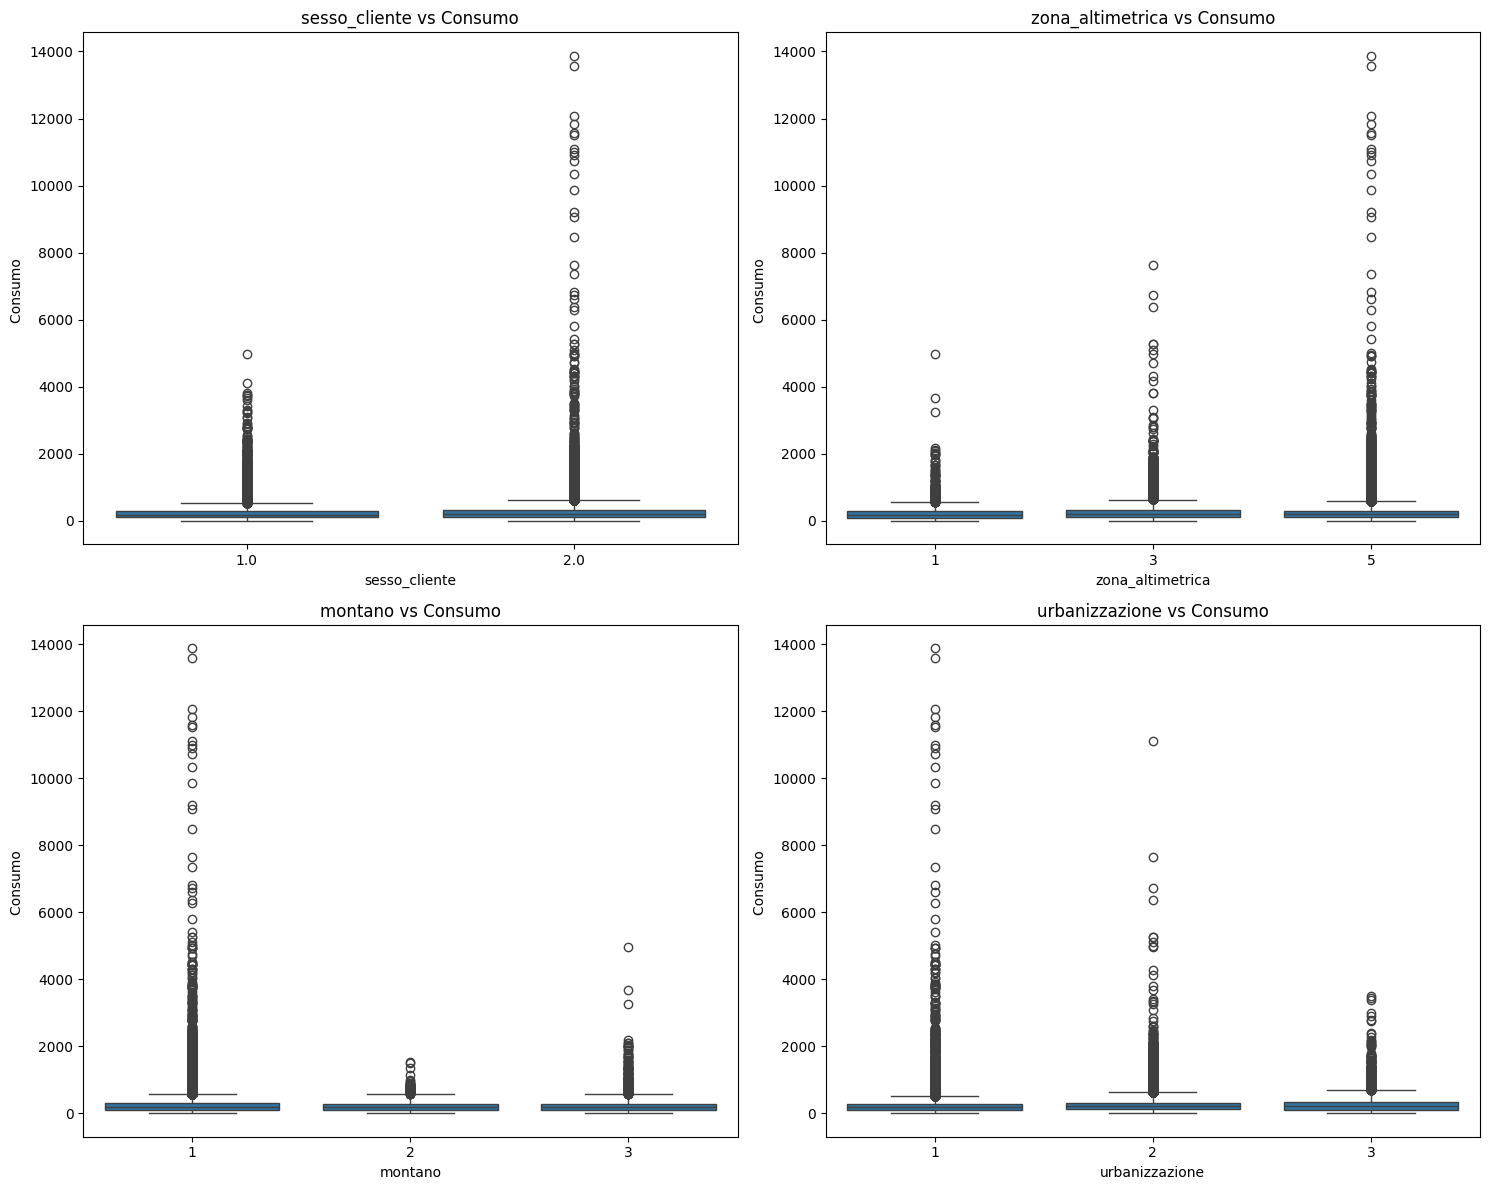

In [21]:
# Box plots to explore Consumo_Annuo across categorical variables
categorical_vars = ['sesso_cliente', 'zona_altimetrica', 'montano', 'urbanizzazione']

plt.figure(figsize=(15, 12))
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=var, y='kWh', data=priv_data)
    plt.title(f'{var} vs Consumo')
    plt.xlabel(var)
    plt.ylabel('Consumo ')

plt.tight_layout()
plt.show()


Mountain areas have higher consumption, also very urbanized areas have high consumption

In [49]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a color map using matplotlib
colormap = plt.get_cmap('plasma')  # Choose your preferred colormap
norm = mcolors.Normalize(vmin=priv_data['kWh'].min(), vmax=priv_data['kWh'].max())


In [50]:
def get_color(value):
    return mcolors.rgb2hex(colormap(norm(value)))

# Add a new column with the color for each point
priv_data['color'] = priv_data['kWh'].apply(get_color)


C:\Users\laura\AppData\Local\Temp\ipykernel_3748\2015107319.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  priv_data['color'] = priv_data['Consumo_Annuo'].apply(get_color)


In [51]:
import folium

# Create a base map centered around the average latitude and longitude
m = folium.Map(location=[priv_data['lati'].mean(), priv_data['long'].mean()], zoom_start=6)

# Add points to the map
for idx, row in priv_data.iterrows():
    folium.CircleMarker(
        location=[row['lati'], row['long']],
        radius=8,
        color=row['color'],  # Use the color generated from Consumo_Annuo
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.6,
        popup=folium.Popup(f'Consumo Annuo: {row["kWh"]}', parse_html=True)
    ).add_to(m)

# Save the map to an HTML file
m.save('map.html')


In [24]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [22]:
# Select relevant columns
columns = ['Categoria_cliente', 'zona_altimetrica', 'superficie', 'urbanizzazione', 'long', 'lati', 'mese', 'kWh']
data = dataset[columns]

# Handle categorical variables (e.g., one-hot encoding)
data = pd.get_dummies(data, columns=['Categoria_cliente', 'zona_altimetrica', 'urbanizzazione', 'mese'])

# Separate features from the target variable if needed
# features = data.drop(columns=['target_variable'])

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


In [25]:
# Initialize PCA
pca = PCA(n_components=5)  

# Fit and transform the data
principal_components = pca.fit_transform(scaled_data)

# Convert the result to a DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3','PC4','PC5'])


In [26]:
print(pca_df.head())
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")


        PC1       PC2       PC3       PC4       PC5
0  2.428692 -1.725977  0.709284  1.021666  0.815399
1  2.427095 -1.657938  0.650467  1.022948  0.816476
2 -0.121220  1.586274 -0.283180 -0.746173 -0.809992
3  1.550126 -1.299423  0.752695  0.311647 -0.299672
4 -1.964987  2.364147  0.681706  0.911198  0.209117
Explained variance ratio: [0.10777083 0.0674772  0.06096674 0.05700911 0.04197164]


In [27]:
loadings = pca.components_

# Create a DataFrame to visualize the loadings
loadings_df = pd.DataFrame(data=loadings, columns=data.columns, index=[f'PC{i+1}' for i in range(loadings.shape[0])])

# Display the loadings DataFrame
print(loadings_df)

     superficie      long      lati       kWh  Categoria_cliente_AZN  \
PC1    0.249571 -0.182393 -0.341526  0.005310               0.031767   
PC2   -0.120447 -0.116977 -0.004751 -0.226283              -0.479002   
PC3   -0.039101 -0.064293 -0.047068  0.195610               0.480058   
PC4    0.220099 -0.307077  0.468518 -0.004264               0.085724   
PC5    0.378155  0.548271 -0.295045 -0.003581               0.091005   

     Categoria_cliente_COND  Categoria_cliente_GENP  Categoria_cliente_NPRO  \
PC1                0.027743                0.016996               -0.010151   
PC2               -0.007387               -0.001976                0.018012   
PC3                0.024282                0.003203                0.067899   
PC4               -0.047166               -0.018281                0.015082   
PC5               -0.460402               -0.080403               -0.035052   

     Categoria_cliente_PAMM  Categoria_cliente_PRIV  ...    mese_3    mese_4  \
PC1         

The columns such as superficie (surface), long (longitude), lati (latitude), kWh, Categoria_cliente_AZN (client category AZN), and so on are the original variables.
The values in the matrix indicate the loadings (or weights) of the original variables on each principal component.
Interpretation:
PC1 has a relatively strong positive loading on superficie (0.249571) and a negative loading on long (-0.182393) and lati (-0.341526). This suggests that PC1 captures a combination of these geographic and size-related variables, where larger surfaces tend to increase along PC1, while longitude and latitude decrease.
PC2 is more strongly associated with a negative loading on kWh (-0.226283) and also large negative loading on Categoria_cliente_AZN (-0.479002), suggesting that PC2 may capture variations in energy consumption and certain customer categories.
PC3 shows a high positive loading on kWh (0.195610) and Categoria_cliente_AZN (0.480058), meaning that this component may explain variance in the energy consumption for clients in the AZN category.
For PC4, it seems to be heavily influenced by a strong positive loading on latitude (0.468518) and some smaller weights on other variables, indicating a geographic trend.
Monthly Variables:
The columns labeled mese_3, mese_4, etc., likely represent months (e.g., March, April), and the values indicate how each month contributes to the variance explained by the different PCs.
For example, PC2 has a positive weight in mese_7 (July) (0.002531) and mese_8 (August) (0.013233), suggesting that this component may capture seasonal variation.
Key Takeaways:
PC1 captures spatial features (size and geography).
PC2 is related to energy consumption and specific customer categories.
PC3 appears to explain further variance in energy consumption, especially for the AZN category.
The monthly columns suggest some seasonal trends, with certain PCs capturing variance across different times of the year.

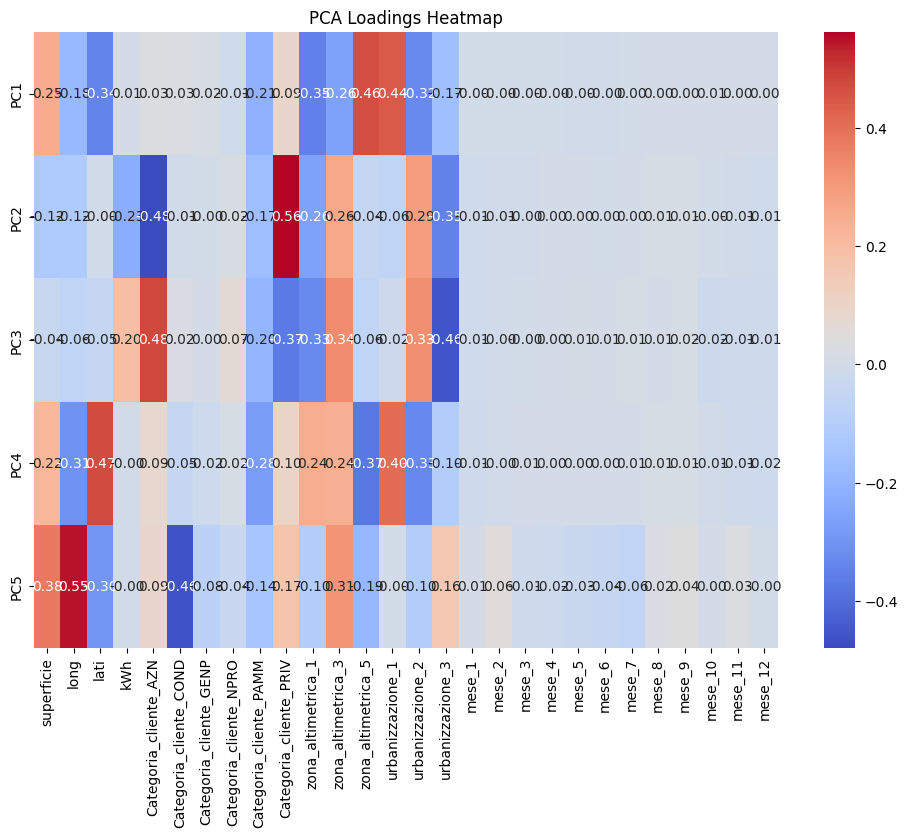

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap of the loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA Loadings Heatmap')
plt.show()


Modelling consumption (kWh):

- preparing dataset for modelling

In [29]:
dataset.head()

,Unnamed: 0,Id_Cliente,Id_Sito,Categoria_cliente,anno_nascita_cliente,mese_nascita_cliente,giorno_nascita_cliente,sesso_cliente,Comune_sede,Comune_sped,...,urbanizzazione,long,lati,time,mese,kWh,kWh_giorn,year,month_num,month_year
0,1,2031,6730,AZN,NaN,NaN,NaN,NaN,100005,100005,...,1,9.189982,45.46420,1,10,2181,70.354839,2016,10,Oct 2016
1,2,5163,6209,AZN,NaN,NaN,NaN,NaN,48017,48017,...,1,9.189982,45.46420,1,10,618,19.935484,2016,10,Oct 2016
2,3,10071,12219,PRIV,35.0,3.0,4.0,2.0,108030,108030,...,2,9.152425,45.66112,1,10,579,18.677419,2016,10,Oct 2016
3,4,10664,12938,AZN,NaN,NaN,NaN,NaN,48043,48043,...,1,9.298131,45.49200,1,10,567,18.290323,2016,10,Oct 2016
4,5,10904,13209,PRIV,71.0,8.0,22.0,2.0,13043,13043,...,2,9.125326,45.77277,1,10,360,11.612903,2016,10,Oct 2016


In [16]:
dataset=dataset.drop(['Unnamed: 0','Id_Cliente','Id_Sito'],axis=1)
dataset.head()

,Categoria_cliente,anno_nascita_cliente,mese_nascita_cliente,giorno_nascita_cliente,sesso_cliente,Comune_sede,Comune_sped,Fattura_Via_Email,Comune_fornitura,Consumo_Annuo,...,altitudine,montano,superficie,urbanizzazione,long,lati,time,mese,kWh,kWh_giorn
0,AZN,NaN,NaN,NaN,NaN,100005,100005,1,15146,47736,...,230,1,182,1,9.189982,45.46420,1,10,2181,70.354839
1,AZN,NaN,NaN,NaN,NaN,48017,48017,1,15146,13091,...,230,1,182,1,9.189982,45.46420,1,10,618,19.935484
2,PRIV,35.0,3.0,4.0,2.0,108030,108030,1,108030,6958,...,341,1,8,2,9.152425,45.66112,1,10,579,18.677419
3,AZN,NaN,NaN,NaN,NaN,48043,48043,1,15205,8500,...,222,1,17,1,9.298131,45.49200,1,10,567,18.290323
4,PRIV,71.0,8.0,22.0,2.0,13043,13043,1,13043,3496,...,563,1,6,2,9.125326,45.77277,1,10,360,11.612903


In [31]:
# look at NAs
dataset.isna().sum()

Categoria_cliente             0
anno_nascita_cliente      71924
mese_nascita_cliente      71924
giorno_nascita_cliente    71924
sesso_cliente             71924
Comune_sede                   0
Comune_sped                   0
Fattura_Via_Email             0
Comune_fornitura              0
Consumo_Annuo                 0
Opzione_tariffaria            0
Potenza                       0
Tipo_pagamento                0
Scadenza                      0
comune                        0
zona_altimetrica              0
altitudine                    0
montano                       0
superficie                    0
urbanizzazione                0
long                          0
lati                          0
time                          0
mese                          0
kWh                           0
kWh_giorn                     0
year                          0
month_num                     0
month_year                    0
dtype: int64

In [17]:
dataset=dataset.drop(['anno_nascita_cliente',	'mese_nascita_cliente',	'giorno_nascita_cliente'],axis=1)


In [19]:
# there are collinear variables: 
dataset = dataset.drop(['Comune_sped','Comune_fornitura','Consumo_Annuo','comune','zona_altimetrica','montano','kWh_giorn','month_year','time'],axis=1)

In [20]:
# there is no sex for the industries and we had seen it doesn't impact private so we drop it
dataset = dataset.drop(['sesso_cliente'],axis=1)

In [21]:
# convert caget to num
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()

dataset['Fattura_Via_Email'] = number.fit_transform(dataset['Fattura_Via_Email'].astype('str'))
dataset['Opzione_tariffaria'] = number.fit_transform(dataset['Opzione_tariffaria'].astype('str'))
dataset['Scadenza'] = number.fit_transform(dataset['Scadenza'].astype('str'))
dataset['Tipo_pagamento'] = number.fit_transform(dataset['Tipo_pagamento'].astype('str'))
dataset['urbanizzazione'] = number.fit_transform(dataset['urbanizzazione'].astype('str'))
dataset['Categoria_cliente'] = number.fit_transform(dataset['Categoria_cliente'].astype('str'))
dataset['mese'] = number.fit_transform(dataset['mese'].astype('str'))


In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(z):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = z.columns
    vif["VIF"] = [variance_inflation_factor(z.values, i) for i in range(z.shape[1])]

    return(vif)

z = dataset.iloc[:,0:10]
calc_vif(z)

,variables,VIF
0,Categoria_cliente,10.890673
1,Comune_sede,1.731395
2,Fattura_Via_Email,4.059360
3,Opzione_tariffaria,14.261970
4,Potenza,1.310655
5,Tipo_pagamento,3.003340
6,Scadenza,3.436923
7,altitudine,4.088285
8,superficie,1.528866
9,urbanizzazione,3.001912


In [22]:
# define our varibale of interest: 

y = dataset['kWh']
X = dataset.drop(columns=['kWh'])

In [23]:
# splitting dataset into training and test (in ratio 80:20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# we fit the model on the train set and calculate performance on the test set

In [24]:
# standardizing the variables 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Modelling

In [12]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from pygam import LinearGAM

In [25]:
# Define a dictionary to store MSE values for all models
mse_dict = {}

# Function for Linear Regression
def evaluate_linear_regression(X_train_scaled, X_test_scaled, y_train, y_test):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)
    y_pred = lin_reg.predict(X_test_scaled)
    mse_dict['Linear Regression'] = mean_squared_error(y_test, y_pred)
    print(f"Linear Regression: MSE = {mse_dict['Linear Regression']}")
    return mse_dict

mse_dict = evaluate_linear_regression(X_train_scaled, X_test_scaled, y_train, y_test)


Linear Regression: MSE = 10881377.77971937


In [42]:
# Function for Lasso Regression
def evaluate_lasso_regression(X_train_scaled, X_test_scaled, y_train, y_test):
    lasso = Lasso()
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)
    mse_dict['Lasso'] = mean_squared_error(y_test, y_pred)
    print(f"Lasso: MSE = {mse_dict['Lasso']}")
    return mse_dict
mse_dict = evaluate_lasso_regression(X_train_scaled, X_test_scaled, y_train, y_test)


Lasso: MSE = 10883560.074613957


In [43]:
# Function for Ridge Regression
def evaluate_ridge_regression(X_train_scaled, X_test_scaled, y_train, y_test):
    ridge = Ridge()
    ridge.fit(X_train_scaled, y_train)
    y_pred = ridge.predict(X_test_scaled)
    mse_dict['Ridge'] = mean_squared_error(y_test, y_pred)
    print(f"Ridge: MSE = {mse_dict['Ridge']}")
    return mse_dict
mse_dict = evaluate_ridge_regression(X_train_scaled, X_test_scaled, y_train, y_test)


Ridge: MSE = 10883841.23673892


In [44]:
# Function for Decision Tree Regressor
def evaluate_decision_tree(X_train_scaled, X_test_scaled, y_train, y_test):
    tree = DecisionTreeRegressor()
    tree.fit(X_train_scaled, y_train)
    y_pred = tree.predict(X_test_scaled)
    mse_dict['Decision Tree'] = mean_squared_error(y_test, y_pred)
    print(f"Decision Tree: MSE = {mse_dict['Decision Tree']}")
    return mse_dict
mse_dict = evaluate_decision_tree(X_train_scaled, X_test_scaled, y_train, y_test)


Decision Tree: MSE = 4057556.657575632


In [45]:
# Function for Random Forest Regressor
def evaluate_random_forest(X_train_scaled, X_test_scaled, y_train, y_test):
    forest = RandomForestRegressor()
    forest.fit(X_train_scaled, y_train)
    y_pred = forest.predict(X_test_scaled)
    mse_dict['Random Forest'] = mean_squared_error(y_test, y_pred)
    print(f"Random Forest: MSE = {mse_dict['Random Forest']}")
    return mse_dict
mse_dict = evaluate_random_forest(X_train_scaled, X_test_scaled, y_train, y_test)


Random Forest: MSE = 2887767.712858835


In [46]:
# Function for Generalized Additive Model (GAM)
def evaluate_gam(X_train_scaled, X_test_scaled, y_train, y_test):
    gam = LinearGAM().fit(X_train_scaled, y_train)
    y_pred = gam.predict(X_test_scaled)
    mse_dict['GAM'] = mean_squared_error(y_test, y_pred)
    print(f"GAM: MSE = {mse_dict['GAM']}")
    return mse_dict
mse_dict = evaluate_gam(X_train_scaled, X_test_scaled, y_train, y_test)


GAM: MSE = 9021921.177013904


In [47]:
# Function for Neural Network (Multi-layer Perceptron Regressor)
def evaluate_neural_network(X_train_scaled, X_test_scaled, y_train, y_test):
    mlp = MLPRegressor(max_iter=1000)
    mlp.fit(X_train_scaled, y_train)
    y_pred = mlp.predict(X_test_scaled)
    mse_dict['Neural Network'] = mean_squared_error(y_test, y_pred)
    print(f"Neural Network: MSE = {mse_dict['Neural Network']}")
    return mse_dict
mse_dict = evaluate_neural_network(X_train_scaled, X_test_scaled, y_train, y_test)


Neural Network: MSE = 9047016.934747458


c:\Users\laura\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [48]:
print(mse_dict)


{'Linear Regression': 10883856.382842002, 'Lasso': 10883560.074613957, 'Ridge': 10883841.23673892, 'Decision Tree': 4057556.657575632, 'Random Forest': 2887767.712858835, 'GAM': 9021921.177013904, 'Neural Network': 9047016.934747458}


Model interpretation

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

forest = RandomForestRegressor()
forest.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = forest.predict(X_test_scaled)

# Calculate the MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Random Forest: MSE = {mse}")


Random Forest: MSE = 2774454.3151847976


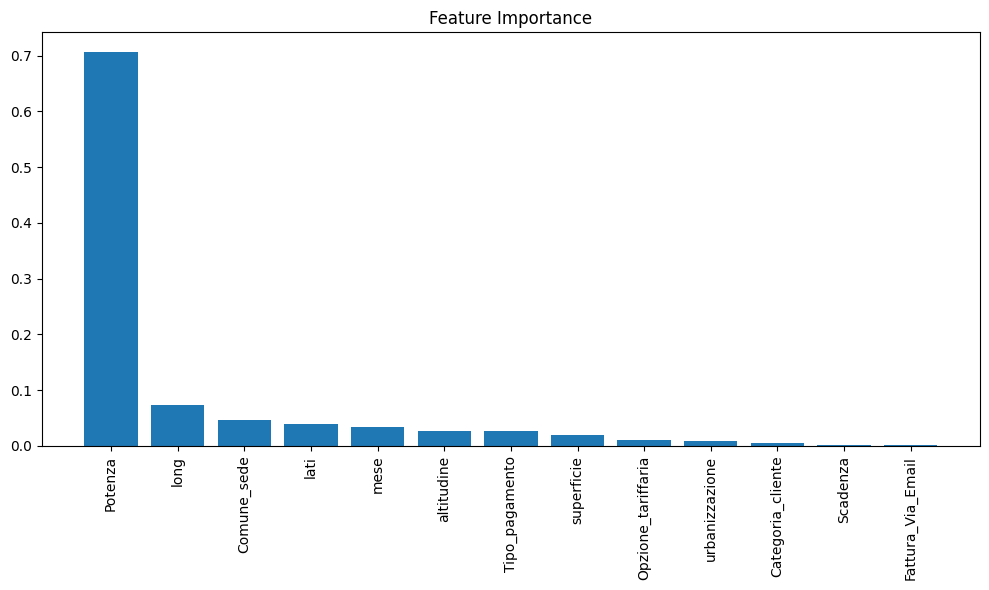

In [27]:
# feature importance
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the original column names from X_train
column_names = X_train.columns  # Make sure X_train is a DataFrame with column names

# If X_train_scaled is a NumPy array, convert it to a DataFrame
import pandas as pd
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=column_names)

# Get feature importance from the trained Random Forest model
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train_scaled_df.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_scaled_df.shape[1]), X_train_scaled_df.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


In [29]:
# permutation importance
from sklearn.inspection import permutation_importance

# Perform permutation importance
result = permutation_importance(forest, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()

# Plot the permutation importance
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train_scaled_df.columns[sorted_idx])
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()
